In [2]:
# LECTURE 22: The HiggsML challenge, dataset of simulated events from the ATLAS particle detector at CERN.
# The task is that of classifying these features against a set of labels, which are either s (source) or b (background).
# 2.5 x 10^5 samples with each 30 features - missing values are indicated as -999.

# CREATE A NEURAL NETWORK TO DISTINGUISH SIGNAL AND BACKGROUND

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import roc_auc_score, make_scorer, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

In [5]:
# training sample D = {x, y, w} || x = features vector || y = label || w = weight
# azimuthal angles are in radian in the [−π, +π[ range
# Energy, mass, momentum are all in GeV
# Undefined variables' value is −999.0

# DATAFRAME
df = pd.read_csv('atlas-higgs-challenge-2014-v2.csv')
print(list(df.columns))

# Features - shape (818238, 32)
features = df.drop(columns=['EventId', 'Weight', 'Label', 'KaggleWeight', 'KaggleSet']) # leave only the columns to use as input to the classifier

# Labels - shape (818238,)
labels = df['Label'].map({'s': 1, 'b': 0})  # convert s -> 1, b -> 0

# Event weight - (818238,) -> Statistical weight of the simulated event, how many times would that event be expected in reality
weights = df['Weight']

['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt', 'Weight', 'Label', 'KaggleSet', 'KaggleWeight']


In [6]:
# FEATURES SELECTION
missing_perc = pd.DataFrame(index=features.columns, columns=['Missing total', 'Missing s/tot', 'Missing b/tot', 'Missing s/s', 'Missing b/b'])

# For each column, compute the percentage of missing values
n_total = len(features)
n_s = (labels == 1).sum()
n_b = (labels == 0).sum()

for col in features.columns:
    total_missing = (features[col] == -999.0).sum() / n_total * 100 # percentage of missing values across the entire dataset

    # percentage of missing values from s or b events relative to total
    missing_s_tot = (features.loc[labels == 1, col] == -999.0).sum() / n_total * 100
    missing_b_tot = (features.loc[labels == 0, col] == -999.0).sum() / n_total * 100

    # percentage of missing values within all s or b events
    missing_s_s = (features.loc[labels == 1, col] == -999.0).sum() / n_s * 100
    missing_b_b = (features.loc[labels == 0, col] == -999.0).sum() / n_b * 100

    missing_perc.loc[col] = [total_missing, missing_s_tot, missing_b_tot, missing_s_s, missing_b_b]

# Sort by total percentage descending and filter only those with at least one missing value
missing_perc = missing_perc.astype(float).sort_values(by='Missing total', ascending=False)
missing_perc = missing_perc[missing_perc['Missing total'] > 0]

print()
pd.set_option('display.float_format', '{:.2f} %'.format)
print("Columns with missing values (-999.0):")
print(missing_perc)
print()


Columns with missing values (-999.0):
                        Missing total  Missing s/tot  Missing b/tot  \
DER_deltaeta_jet_jet          70.91 %        21.15 %        49.77 %   
DER_mass_jet_jet              70.91 %        21.15 %        49.77 %   
DER_lep_eta_centrality        70.91 %        21.15 %        49.77 %   
DER_prodeta_jet_jet           70.91 %        21.15 %        49.77 %   
PRI_jet_subleading_pt         70.91 %        21.15 %        49.77 %   
PRI_jet_subleading_phi        70.91 %        21.15 %        49.77 %   
PRI_jet_subleading_eta        70.91 %        21.15 %        49.77 %   
PRI_jet_leading_pt            40.01 %        10.13 %        29.88 %   
PRI_jet_leading_eta           40.01 %        10.13 %        29.88 %   
PRI_jet_leading_phi           40.01 %        10.13 %        29.88 %   
DER_mass_MMC                  15.23 %         1.12 %        14.11 %   

                        Missing s/s  Missing b/b  
DER_deltaeta_jet_jet        61.90 %      75.59 %  
DER_ma

In [7]:
# A) Exclude every feature with more than 20% of missing values -> only DER_mass_MMC remains (15.23%)
features_A = features.drop(columns=missing_perc[missing_perc['Missing total'] > 20].index)

# B) Exclude every feature with more than 50% of missing values -> PRI_jet_leading_pt, PRI_jet_leading_eta, PRI_jet_leading_phi remain too (40.01%)
features_B = features.drop(columns=missing_perc[missing_perc['Missing total'] > 50].index)

# ELIMINATE ALL ROWS WITH MISSING VALUES
features_A = features_A[~(features_A == -999.0).any(axis=1)]
labels_A = labels[features_A.index]
weights_A = weights[features_A.index]
print(f"\nShape (A): {features_A.shape}, Labels: {labels_A.shape}")

features_B = features_B[~(features_B == -999.0).any(axis=1)]
labels_B = labels[features_B.index]
weights_B = weights[features_B.index]
print(f"Shape (B): {features_B.shape}, Labels: {labels_B.shape}")

# C) Exclude every feature with more than 50% of missing values + substitute missing values with 0 + dummy variable
features_C = features.drop(columns=missing_perc[missing_perc['Missing total'] > 50].index)
labels_C = labels[features_C.index]
weights_C = weights[features_C.index]
print(f"Shape (C): {features_C.shape}, Labels: {labels_C.shape}")

# Eliminate the rows where DER_mass_MMC is -999.0 -> very important variable for signal discrimination (Higgs boson mass)
mask_valid_mass = features_C['DER_mass_MMC'] != -999.0

features_C = features_C[mask_valid_mass].copy() # features_C is an independent copy -> preventing unintended modifications to the original DataFrame
labels_C = labels_C[mask_valid_mass].copy()
weights_C = weights_C[mask_valid_mass].copy()

print(f"Shape (C) (no DER_mass_MMC): {features_C.shape}, Labels: {labels_C.shape}")


Shape (A): (693636, 20), Labels: (693636,)
Shape (B): (451651, 23), Labels: (451651,)
Shape (C): (818238, 23), Labels: (818238,)
Shape (C) (no DER_mass_MMC): (693636, 23), Labels: (693636,)


In [8]:
# C) SUBSTITUTION -999 -> 0 + DUMMY COLUMNS -> to indicate whether the original value was missing
# Missing values cannot be imputed using mean or other methods -> physical quantities that are not present in that particular process
# For example, if no jets are present, it makes no sense to define quantities related to jets
print("\n>>> Strategy C: zero substitution and dummy variables")

col_impute = ['PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi'] # columns with missing values to impute and dummy

# Substitution and creation of dummy columns
for col in col_impute:
    print(f"Processing column: {col}")

    # Creation of new column (dummy): missing -> 1, not missing -> 0
    features_C[f'DUMMY_{col}'] = (features_C[col] == -999.0).astype(int) # .astype(int) -> transform boolean type in 1 or 0
    print(f" - 'DUMMY_{col}' column is created")

    # Replacement of all -999.0 in the original column with 0
    features_C[col] = features_C[col].replace(-999.0, 0)

print(f"\n> Final shape of features_C: {features_C.shape}")
print()


>>> Strategy C: zero substitution and dummy variables
Processing column: PRI_jet_leading_pt
 - 'DUMMY_PRI_jet_leading_pt' column is created
Processing column: PRI_jet_leading_eta
 - 'DUMMY_PRI_jet_leading_eta' column is created
Processing column: PRI_jet_leading_phi
 - 'DUMMY_PRI_jet_leading_phi' column is created

> Final shape of features_C: (693636, 26)



In [9]:
# >> NEURAL NETWORK C
X_train, X_test, y_train, y_test = train_test_split(features_C, labels_C, test_size=0.2, stratify=labels_C, random_state=42) # stratify: maintain proportion between 0 and 1
train_weights = weights.loc[X_train.index]
test_weights = weights.loc[X_test.index]

# Scaler - z-score normalization: transform the data so that each feature has a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# From pandas.Series to numpy.ndarray - better for MLPClassifier
y_train = y_train.values
y_test = y_test.values
train_weights = train_weights.values
test_weights = test_weights.values

# NEURAL NETWORK and CROSS VALIDATION
# hyperparameters grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(30, 20), (40, 20), (50, 30)], # (N,) = 1 layer with N neurons || (N, M) = 2 layers with N and M neurons
    'activation': ['relu', 'tanh'], # standard activation functions: Rectified Linear Unit and Hyperbolic Tangent
    'learning_rate_init': [0.0001, 0.005, 0.001], # learning rate
    'alpha': [0.0001, 0.001], # L2 regularization parameters to prevent overfitting: larger values ​​increase penalty for large weights, simplify model
}

# Definition of the evaluation metric (scoring) -> in unbalanced dataset, AUC is often more reliable than accuracy
# e.g. most of events are b, it's possible to achieve high accuracy by always predicting b -> not useful to identify signal
auc_scorer = make_scorer(roc_auc_score, greater_is_better = True)

# NN initialization with random values
mlp = MLPClassifier(early_stopping = True, solver = 'adam', max_iter = 150, random_state = 42) # stop early if validation score does not improve
# max_iter = maximum number of epochs the training algorithm will attempt to run

# Configuring StratifiedKFold for cross-validation (Stratified -> class ratio s/b maintained)
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# GridSearchCV definition (GridSearchCV cannot use the sample weight -> optimization without it)
grid_search = GridSearchCV(estimator = mlp, # model to optimaze
                           param_grid = param_grid,
                           scoring = auc_scorer,
                           cv = cv,
                           verbose = 3, # controls the amount of output during execution -> higher value shows more detail
                           n_jobs = -1, # using all cores
                           return_train_score = True)

grid_search.fit(X_train_scaled, y_train)
print("\n >> GridSearchCV completed!")

print(f"\nBest parameters found by GridSearchCV: {grid_search.best_params_}") # best hyperparameters
print(f"Best AUROC score found (mean across CV folds): {grid_search.best_score_:.4f}") # mean score of AUROC for best hyperparameters on validation fold

# BEST MODEL IDENTIFIED: best_estimator_ -> instance of the model with the best hyperparameters
best_mlp = grid_search.best_estimator_
print("\nBest MLPClassifier model (with optimal hyperparameters):")
print(best_mlp)

Fitting 5 folds for each of 36 candidates, totalling 180 fits

 >> GridSearchCV completed!

Best parameters found by GridSearchCV: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 30), 'learning_rate_init': 0.001}
Best AUROC score found (mean across CV folds): 0.8083

Best MLPClassifier model (with optimal hyperparameters):
MLPClassifier(alpha=0.001, early_stopping=True, hidden_layer_sizes=(50, 30),
              max_iter=150, random_state=42)


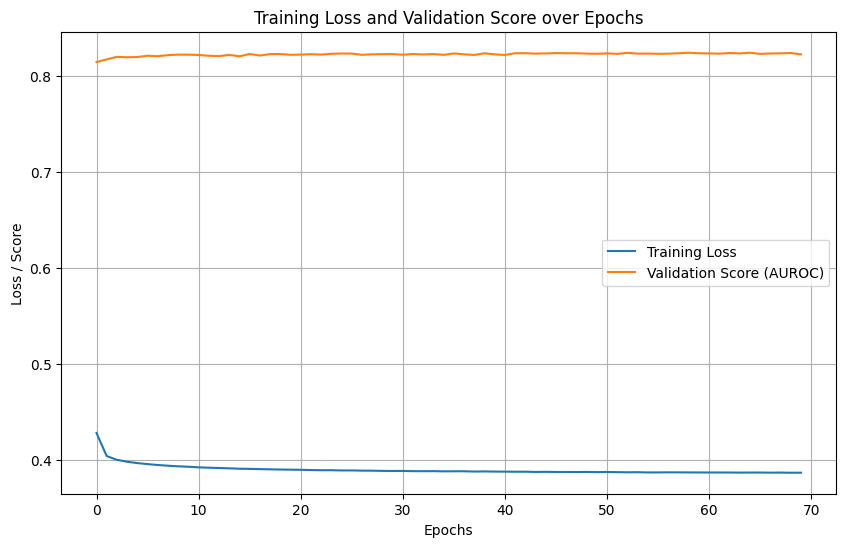

In [ ]:
# TRAINING LOSS FUNCTION AND VALIDATION SCORE

plt.figure(figsize=(10, 6))

plt.plot(best_mlp.loss_curve_, label='Training Loss')
plt.plot(best_mlp.validation_scores_, label='Validation Score (AUROC)')

plt.title('Training Loss and Validation Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss / Score')
plt.legend()
plt.grid(True)
plt.show()


 > Evaluating the best model on the test set
AUROC on test set (weighted): 0.9117


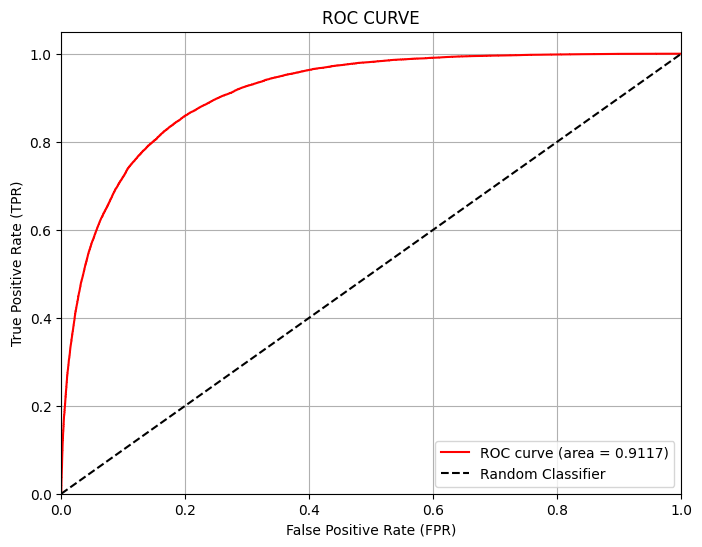

In [11]:
# MODEL PERFORMANCE EVALUATION ON UNSEEN DATA (TEST SET)
print("\n > Evaluating the best model on the test set")

# Test set probability predictions for each class
y_pred_proba = best_mlp.predict_proba(X_test_scaled)[:, 1] # [:, 1] -> probabilities for s class selected

# Calcolate AUROC on test set, using the weights
test_auc_C = roc_auc_score(y_test, y_pred_proba, sample_weight=test_weights)
print(f"AUROC on test set (weighted): {test_auc_C:.4f}")

# ROC PLOT to visualise the performance of a binary classifier
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, sample_weight=test_weights)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC curve (area = {test_auc_C:.4f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title("ROC CURVE")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [12]:
# WEIGHTED ACCURACY (less important than AUROC in this case)
y_pred = best_mlp.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred, sample_weight=test_weights)
print(f"Weighted Accuracy on test set: {accuracy:.4f}")

Weighted Accuracy on test set: 0.9089



Confusion Matrix on test set: [[73879 10774]
 [13825 40250]]


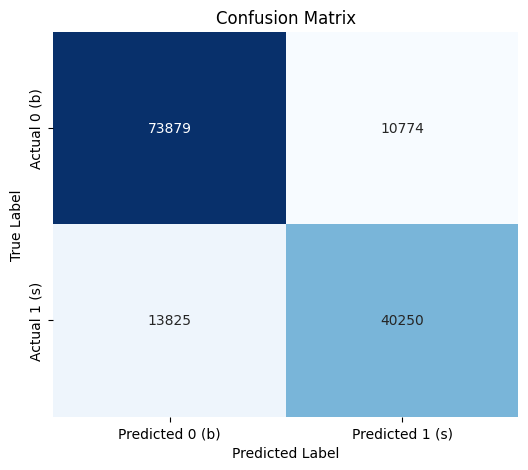

In [13]:
# CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred) # cannot have weighted confusion matrix with scikit-learn
print(f"\nConfusion Matrix on test set: {cm}")

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0 (b)', 'Predicted 1 (s)'],
            yticklabels=['Actual 0 (b)', 'Actual 1 (s)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Precision, recall, F1-score for class 1 (s) -> weighted as the set is unbalanced
# pos_label=1 -> select class 1 as the positive one

# Of all events PREDICTED as s by the model, how many were ACTUALLY s? -> purity of positive predictions
precision = precision_score(y_test, y_pred, pos_label=1, sample_weight=test_weights)

# Of all events that were s in the test set, how many were CORRECTLY IDENTIFIED by the model? -> completeness of positive predictions
recall = recall_score(y_test, y_pred, pos_label=1, sample_weight=test_weights)

# Overall effectiveness of the model in classifying the signal -> harmonic mean between the Precision and the Recall of the s
f1 = f1_score(y_test, y_pred, pos_label=1, sample_weight=test_weights)

# low f1 score -> recall/precision high, precision/recall low -> model classify everything as s/b
# high f1 score -> both precision and recall are high

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.0178
Recall: 0.6991
F1-Score: 0.0348



APS on test set: 0.0500
APS of Random Classifier: 0.3898


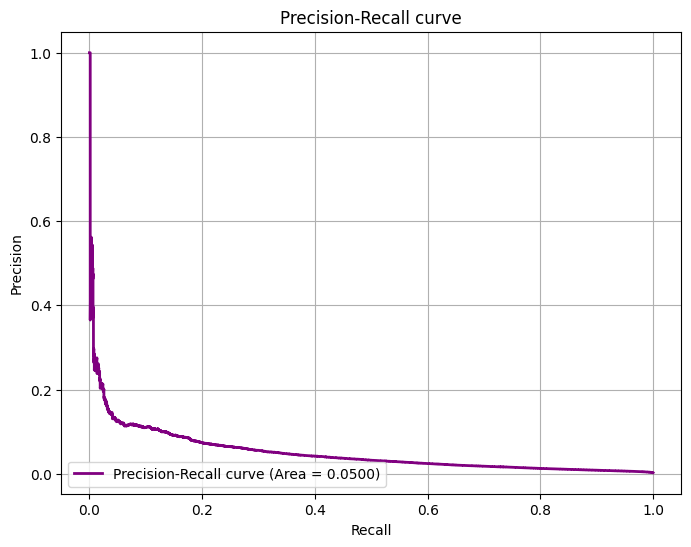

In [15]:
# PRECISION-RECALL CURVE: unbalanced datasets + interest is on the minority class -> very sensitive to class imbalance
# Precision VS Recall for different values of classification thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, sample_weight=test_weights)
aps = average_precision_score(y_test, y_pred_proba, sample_weight=test_weights) # Average Precision Score = area of PR curve

# Low APS -> difficult to achieve high accuracy while maintaining good recall for such a rare class (HIGGS BOSON)
# -> still higher than random classifier
print(f"\nAPS on test set: {aps:.4f}")

# APS of a Random Classifier -> APS = proportion of the class 1 in the dataset
random_aps = (y_test == 1).sum() / len(y_test)
print(f"APS of Random Classifier: {random_aps:.4f}")

# PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'Precision-Recall curve (Area = {aps:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()